In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/PC/Desktop/Python/Datasets/monthly-milk-production-pounds.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


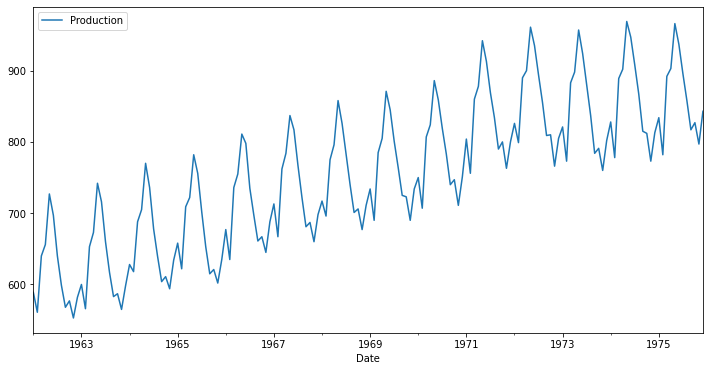

In [4]:
df.plot(figsize=(12,6))

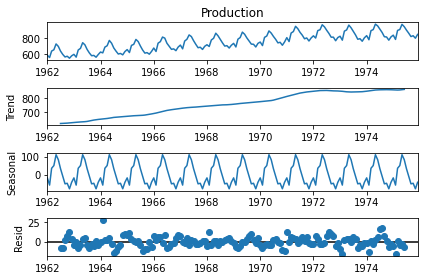

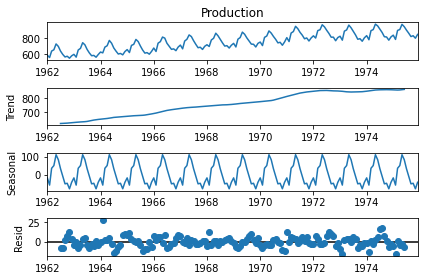

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Production'])
results.plot()

In [6]:
len(df)

168

In [7]:
train = df.iloc[:156]
test = df.iloc[156:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
X,y = generator[0]

In [15]:
X.shape

(1, 3, 1)

In [16]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 21s 5ms/step - loss: 0.0695
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0255
Epoch 3/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 4/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0091
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 8/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 9/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 10/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 11/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 12/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 13/50
144/144 [===

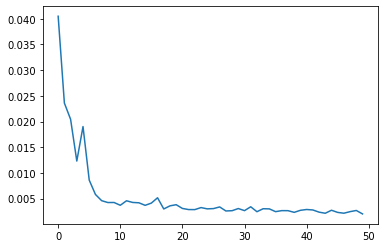

In [20]:

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [21]:
last_train_batch = scaled_train[-12:]

In [22]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [23]:

model.predict(last_train_batch)

array([[0.6507993]], dtype=float32)

In [24]:
scaled_test[0]

array([0.67548077])

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [26]:
test_predictions

[array([0.6507993], dtype=float32),
 array([0.636461], dtype=float32),
 array([0.81795764], dtype=float32),
 array([0.8896998], dtype=float32),
 array([0.98326313], dtype=float32),
 array([0.9671918], dtype=float32),
 array([0.89769006], dtype=float32),
 array([0.7965683], dtype=float32),
 array([0.67628074], dtype=float32),
 array([0.6278031], dtype=float32),
 array([0.57559204], dtype=float32),
 array([0.6134771], dtype=float32)]

In [27]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

<ipython-input-29-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


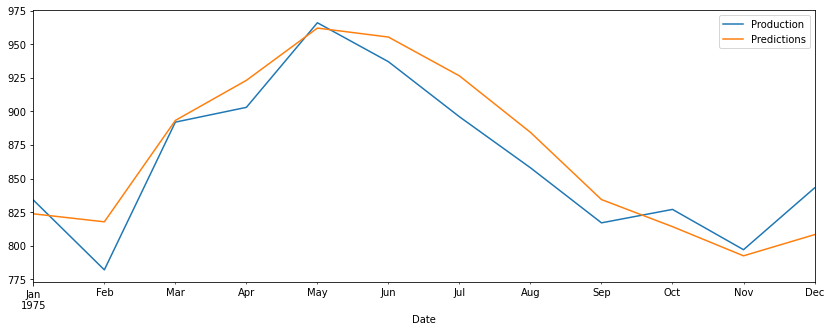

In [30]:
test.plot(figsize=(14,5))

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

21.334593704917076
